In [1]:
import pandas as pd
import torch
import torch.utils.data as tud
import torch.nn as nn
import pickle
from tqdm.notebook import tqdm
import numpy as np
import seaborn as sns
sns.set()

In [2]:
folder = "/home/jarobyte/scratch/inaoe/"

# train data

In [3]:
with open(folder + "EXPLANATION/Expe_NSP/Train_NSP_ANGLO.trans") as file:
    source_train = file.readlines()
print(len(source_train))
source_train[:5]

4499


['DXCL_M_001_I_001 in ther gatalalatical of here\n',
 'DXCL_M_001_I_002 the lasi the megico pari munbo\n',
 'DXCL_M_001_I_003 isin embargo notehiseon a qestianol importanty\n',
 'DXCL_M_001_I_004 is thi racually lone o auropea\n',
 "DXCL_M_001_I_005 monten imental alphormas unless yo're in mexico\n"]

In [4]:
with open(folder + "EXPLANATION/Expe_NSP/Train_NSP_ORG.trans") as file:
    target_train = file.readlines()
print(len(target_train))
target_train[:5]

4499


['DXCL_M_001_I_001 en el caso de la psicología\n',
 'DXCL_M_001_I_002 de la ciudad de méxico para el mundo\n',
 'DXCL_M_001_I_003 y sin embargo no deja de ser una cuestión muy importante\n',
 'DXCL_M_001_I_004 el derecho de la unión europea\n',
 'DXCL_M_001_I_005 mantenimiento de alfombras en la ciudad de méxico\n']

# test data

In [5]:
with open(folder + "EXPLANATION/Expe_NSP/Test_NSP_ANGLO.trans") as file:
    source_test = file.readlines()
print(len(source_test))
source_test[:5]

500


['DXCL_M_089_I_001 this tangular i minsione politic a altiar aser\n',
 'DXCL_M_089_I_002 member of the grouro puning han area and systemas compotationalys\n',
 'DXCL_M_089_I_003 rasonamiento inferencia konlochica deplemenordon\n',
 'DXCL_M_089_I_004 rosenbarin tehas is talls o niedo silima peru\n',
 'DXCL_M_089_I_005 evalrosin the latension melitar fisial lohicas condu tuales elect without conitivea\n']

In [6]:
with open(folder + "EXPLANATION/Expe_NSP/Test_NSP_ORG.trans") as file:
    target_test = file.readlines()
print(len(target_test))
target_test[:5]

500


['DXCL_M_089_I_001 distinguir la dimensión política del ser y hacer\n',
 'DXCL_M_089_I_002 miembros del grupo de ingeniería en sistemas computacionales\n',
 'DXCL_M_089_I_003 razonamiento e inferencia con lógica de primer orden\n',
 'DXCL_M_089_I_004 rosenberg en texas estados unidos y lima perú\n',
 'DXCL_M_089_I_005 evaluación de la atención medidas fisiológicas conductuales y de actividad cognitiva\n']

# numericalization

In [7]:
train = pd.DataFrame.from_dict({"source":source_train, "target":target_train})\
.assign(source = lambda df: df["source"].map(lambda x: x[17:-1]),
        target = lambda df: df["target"].map(lambda x: x[17:-1]))

print(train.shape)
train.head()

(4499, 2)


,source,target
0,in ther gatalalatical of here,en el caso de la psicología
1,the lasi the megico pari munbo,de la ciudad de méxico para el mundo
2,isin embargo notehiseon a qestianol importanty,y sin embargo no deja de ser una cuestión muy ...
3,is thi racually lone o auropea,el derecho de la unión europea
4,monten imental alphormas unless yo're in mexico,mantenimiento de alfombras en la ciudad de méxico


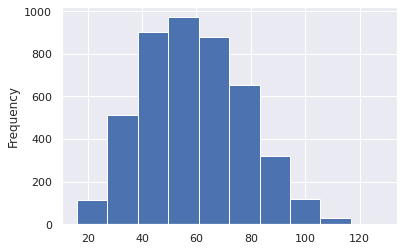

In [8]:
train["source"].map(len).plot.hist()

In [9]:
train["source"].map(len).describe(percentiles = np.linspace(0, 1, 11))

count    4499.000000
mean       58.839964
std        18.399915
min        16.000000
0%         16.000000
10%        36.000000
20%        42.000000
30%        48.000000
40%        53.000000
50%        58.000000
60%        63.000000
70%        68.000000
80%        75.000000
90%        84.000000
100%      128.000000
max       128.000000
Name: source, dtype: float64

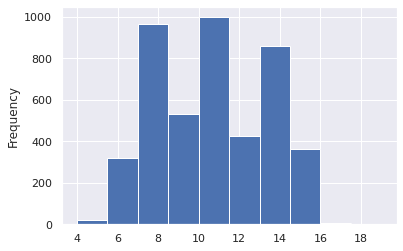

In [10]:
train["target"].map(lambda x: x.split()).map(len).plot.hist()

In [11]:
test = pd.DataFrame.from_dict({"source":source_test, "target":target_test})\
.assign(source = lambda df: df["source"].map(lambda x: x[17:-1]),
        target = lambda df: df["target"].map(lambda x: x[17:-1]))

print(test.shape)
test.head()

(500, 2)


,source,target
0,this tangular i minsione politic a altiar aser,distinguir la dimensión política del ser y hacer
1,member of the grouro puning han area and syste...,miembros del grupo de ingeniería en sistemas c...
2,rasonamiento inferencia konlochica deplemenordon,razonamiento e inferencia con lógica de primer...
3,rosenbarin tehas is talls o niedo silima peru,rosenberg en texas estados unidos y lima perú
4,evalrosin the latension melitar fisial lohicas...,evaluación de la atención medidas fisiológicas...


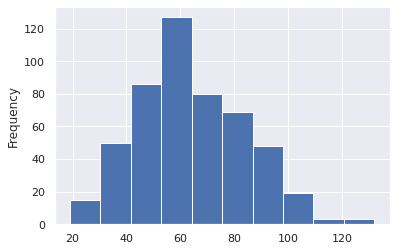

In [12]:
test["source"].map(len).plot.hist()

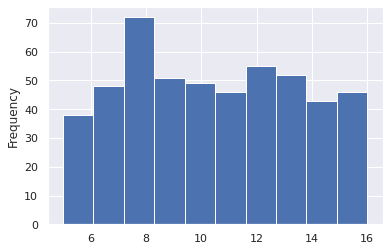

In [13]:
test["target"].map(lambda x: x.split()).map(len).plot.hist()

## vocabularies

In [14]:
chars = set(train["source"].sum()) \
| set(test["source"].sum()) \
| set(train["target"].sum()) \
| set(test["target"].sum())

print(len(chars))
char2i = {c:i for i, c in enumerate(chars, 3)}
char2i["<PAD>"] = 0
char2i["<START>"] = 1
char2i["<END>"] = 2
print(len(char2i))
i2char = {i:c for i, c in enumerate(chars, 3)}
i2char[0] = "<PAD>"
i2char[1] = "<START>"
i2char[2] = "<END>"
print(len(i2char))

35
38
38


In [15]:
chars_vocab = {"char2i":char2i, "i2char":i2char}

In [16]:
words = set(train["target"].map(lambda x: " " + x).sum().split()) \
| set(test["target"].map(lambda x: " " + x).sum().split())

print(len(words))
word2i = {c:i for i, c in enumerate(words, 3)}
word2i["<PAD>"] = 0
word2i["<START>"] = 1
word2i["<END>"] = 2
print(len(word2i))
i2word = {i:c for i, c in enumerate(words, 3)}
i2word[0] = "<PAD>"
i2word[1] = "<START>"
i2word[2] = "<END>"
print(len(i2word))

8787
8790
8790


In [17]:
words_vocab = {"word2i":word2i, "i2word":i2word}

In [18]:
pickle.dump(chars_vocab, open(folder + "nsp/chars.vocab", "wb"))
pickle.dump(words_vocab, open(folder + "nsp/words.vocab", "wb"))

## char

In [47]:
char_source_train = nn.utils.rnn.pad_sequence(train["source"]\
                                              .map(lambda x: [1] + [char2i[c] for c in x] + [2])\
                                              .map(torch.tensor), batch_first = True)
char_source_train.shape

torch.Size([4499, 130])

In [48]:
char_target_train = nn.utils.rnn.pad_sequence(train["target"]\
                                              .map(lambda x: [1] + [char2i[c] for c in x] + [2])\
                                              .map(torch.tensor), batch_first = True)
char_target_train.shape

torch.Size([4499, 130])

In [49]:
char_source_test = nn.utils.rnn.pad_sequence(test["source"]\
                                   .map(lambda x: [1] + [char2i[c] for c in x] + [2])\
                                   .map(torch.tensor), batch_first = True)
char_source_test.shape

torch.Size([500, 134])

In [50]:
char_target_test = nn.utils.rnn.pad_sequence(test["target"]\
                                   .map(lambda x: [1] + [char2i[c] for c in x] + [2])\
                                   .map(torch.tensor), batch_first = True)
char_target_test.shape

torch.Size([500, 123])

In [51]:
torch.save(char_source_train, folder + "nsp/char/source_train.pt")
torch.save(char_target_train, folder + "nsp/char/target_train.pt")
torch.save(char_source_test, folder + "nsp/char/source_test.pt")
torch.save(char_target_test, folder + "nsp/char/target_test.pt")

## word

In [54]:
word_target_train = nn.utils.rnn.pad_sequence(train["target"].map(lambda x: x.split())\
                                   .map(lambda x: [1] + [word2i[c] for c in x] + [2])\
                                   .map(torch.tensor), batch_first = True)
word_target_train.shape

torch.Size([4499, 21])

In [55]:
word_target_test = nn.utils.rnn.pad_sequence(test["target"].map(lambda x: x.split())\
                                   .map(lambda x: [1] + [word2i[c] for c in x] + [2])\
                                   .map(torch.tensor), batch_first = True)
word_target_test.shape

torch.Size([500, 18])

In [56]:
torch.save(word_target_train, folder + "nsp/word/target_train.pt")
torch.save(word_target_test, folder + "nsp/word/target_test.pt")